In [101]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn .model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D ,LSTM ,TimeDistributed
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping , ModelCheckpoint
from keras.layers import Dropout


%matplotlib inline

In [102]:
train = pd.read_csv('../../data/feedback-prize-2021/train.csv')
train.shape

(144293, 8)

In [103]:
TEST_PATH = "../../data/feedback-prize-2021/test"

def get_test_text(a_id):
    a_file = f"{TEST_PATH}/{a_id}.txt"
    with open(a_file, "r") as fp:
        txt = fp.read()
    return txt

def create_df_test():
    test_ids = [f[:-4] for f in os.listdir(TEST_PATH)] #Remove the last 4 characters ('.txt') in the filenames such as '0FB0700DAF44.txt'.
    test_data = []
    for test_id in test_ids:
        text = get_test_text(test_id)
        sentences = nltk.sent_tokenize(text)
        id_sentences = []
        idx = 0 
        for sentence in sentences:
            id_sentence = []
            words = sentence.split()
            # I created this heuristic for mapping words in sentences to "word indices"
            # This is not definitive and might have strong drawbacks and problems
            for w in words:
                id_sentence.append(idx)
                idx+=1
            id_sentences.append(id_sentence)
        test_data += list(zip([test_id] * len(sentences), sentences, id_sentences))
    df_test = pd.DataFrame(test_data, columns=['id', 'discourse_text', 'ids'])
    return df_test

In [104]:
df_test = create_df_test()
df_test.head()

,id,discourse_text,ids
0,DF920E0A7337,Have you ever asked more than one person for h...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,DF920E0A7337,Interviews are a perfect example of seeking mo...,"[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]"
2,DF920E0A7337,"Interviews are seen on the news, in profession...","[29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4..."
3,DF920E0A7337,There are a lot of people that can help you bu...,"[43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 5..."
4,DF920E0A7337,They can all open you up to new ideas.,"[59, 60, 61, 62, 63, 64, 65, 66, 67]"


In [105]:
df_test['predictionstring'] = df_test['ids'].apply(lambda x: ' '.join([str(i) for i in x]))
df_test.head()

,id,discourse_text,ids,predictionstring
0,DF920E0A7337,Have you ever asked more than one person for h...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17
1,DF920E0A7337,Interviews are a perfect example of seeking mo...,"[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]",18 19 20 21 22 23 24 25 26 27 28
2,DF920E0A7337,"Interviews are seen on the news, in profession...","[29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4...",29 30 31 32 33 34 35 36 37 38 39 40 41 42
3,DF920E0A7337,There are a lot of people that can help you bu...,"[43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 5...",43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
4,DF920E0A7337,They can all open you up to new ideas.,"[59, 60, 61, 62, 63, 64, 65, 66, 67]",59 60 61 62 63 64 65 66 67


In [106]:
df_test = df_test.drop('ids', axis=1)

In [107]:
df_test.head()

,id,discourse_text,predictionstring
0,DF920E0A7337,Have you ever asked more than one person for h...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17
1,DF920E0A7337,Interviews are a perfect example of seeking mo...,18 19 20 21 22 23 24 25 26 27 28
2,DF920E0A7337,"Interviews are seen on the news, in profession...",29 30 31 32 33 34 35 36 37 38 39 40 41 42
3,DF920E0A7337,There are a lot of people that can help you bu...,43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
4,DF920E0A7337,They can all open you up to new ideas.,59 60 61 62 63 64 65 66 67


In [8]:
df = train.append(df_test)

## Preprocessing

In [160]:
def clean_text(text, remove_stopwords=True, stem_words=False, lemma=True):
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    text = str(text).lower().split()
    
    if remove_stopwords:
        stops = stopwords.words("english")
        text = [x for x in text if not x in stops]
        
    text = ' '.join(text)
    
    text = re.sub(r"[-()\"#/<>!@&;*:<>{}`'+=~%|.!?,_]", " ", text)
    text = re.sub(r"\]", " ", text)
    text = re.sub(r"\[", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\\", " ", text)
    #text = BAD_SYMBOLS_RE.sub('', text) 
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"  ", " ", text)
    text = re.sub(r"   ", " ", text)
    text = re.sub(r"   ", " ", text)
    text = re.sub(r"0x00", "", text)
    
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stem_words = [stemmer.stem(x) for x in text]
        text = " ".join(text)
        
    if lemma:
        text = text.split()
        lem = WordNetLemmatizer()
        lemmatized = [lem.lemmatize(x, "v") for x in text]
        text = " ".join(text)
        
    return text

In [109]:
%%time
train['cleaned_text'] = train.discourse_text.apply(clean_text)

CPU times: user 39.6 s, sys: 3.62 s, total: 43.2 s
Wall time: 43.2 s


In [110]:
train.iloc[0]['discourse_text']

'Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving.'

In [111]:
train.iloc[0]['cleaned_text']

'modern humans today always phone always phone 5 hours day stop all text back forward group chats social media even driving'

In [112]:
train.head()

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,cleaned_text
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,modern humans today always phone always phone ...
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,really bad consequences stuff happens comes phone
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,certain areas united states ban phones class r...
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,people phones know certain apps apps like face...
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...,driving one way get around people always phone...


In [113]:
x_train, x_test, y_train, y_test = train_test_split(train['discourse_text'], train['discourse_type'], test_size=0.05)

## Word2Vec 

In [114]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

In [115]:
x_train_text = x_train.tolist()
x_test_text = x_test.tolist()

In [116]:
x_train_text[0]

"Psychologically, I think it takes a large toll out of a person's brain. Not telling anyone the problems someone might have, or asking for advice. If someone starts to chose one decision. Then decides to go back and think about the other decisions they may have. It could possibly render the first decision useless. If they decide their first choice was not correct.\xa0Leaving that person lost. Not knowing what the right choice is. Keeping that person thinking about the problem for hours and not letting them move on. If you don't tell anyone about the problems you may have. How are they supposed to know? How are they supposed to help you work things out?"

In [117]:
x_train_text_data = list(sent_to_words(x_train_text))
x_test_text_data = list(sent_to_words(x_test_text))

In [118]:
x_train_text_data[0]

['psychologically',
 'think',
 'it',
 'takes',
 'large',
 'toll',
 'out',
 'of',
 'person',
 'brain',
 'not',
 'telling',
 'anyone',
 'the',
 'problems',
 'someone',
 'might',
 'have',
 'or',
 'asking',
 'for',
 'advice',
 'if',
 'someone',
 'starts',
 'to',
 'chose',
 'one',
 'decision',
 'then',
 'decides',
 'to',
 'go',
 'back',
 'and',
 'think',
 'about',
 'the',
 'other',
 'decisions',
 'they',
 'may',
 'have',
 'it',
 'could',
 'possibly',
 'render',
 'the',
 'first',
 'decision',
 'useless',
 'if',
 'they',
 'decide',
 'their',
 'first',
 'choice',
 'was',
 'not',
 'correct',
 'leaving',
 'that',
 'person',
 'lost',
 'not',
 'knowing',
 'what',
 'the',
 'right',
 'choice',
 'is',
 'keeping',
 'that',
 'person',
 'thinking',
 'about',
 'the',
 'problem',
 'for',
 'hours',
 'and',
 'not',
 'letting',
 'them',
 'move',
 'on',
 'if',
 'you',
 'don',
 'tell',
 'anyone',
 'about',
 'the',
 'problems',
 'you',
 'may',
 'have',
 'how',
 'are',
 'they',
 'supposed',
 'to',
 'know',
 'how

In [119]:
train_text_data = list(sent_to_words(train["discourse_text"]))
test_text_data = list(sent_to_words(df_test["discourse_text"]))

In [120]:
train_text_data[0]

['modern',
 'humans',
 'today',
 'are',
 'always',
 'on',
 'their',
 'phone',
 'they',
 'are',
 'always',
 'on',
 'their',
 'phone',
 'more',
 'than',
 'hours',
 'day',
 'no',
 'stop',
 'all',
 'they',
 'do',
 'is',
 'text',
 'back',
 'and',
 'forward',
 'and',
 'just',
 'have',
 'group',
 'chats',
 'on',
 'social',
 'media',
 'they',
 'even',
 'do',
 'it',
 'while',
 'driving']

In [121]:
%%time
w2v_model = gensim.models.Word2Vec(train_text_data, size=100, min_count=1, window=5, iter=50)

CPU times: user 6min 16s, sys: 2.81 s, total: 6min 19s
Wall time: 2min 14s


In [122]:
w2v_model['time']

/Users/nehapawar/Desktop/neha/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 4.063873  , -0.56036234, -3.543371  ,  3.308613  ,  2.470335  ,
        3.9348116 , -0.20423765, -2.4504852 , -4.619333  ,  0.29660544,
        3.0000267 , -2.4854748 ,  0.15120277,  0.5986737 , -0.5802435 ,
       -3.3488724 ,  0.8353344 , -2.8028464 ,  1.1314281 ,  1.3978374 ,
        1.439331  ,  0.41071275, -3.8934608 , -0.14500418,  3.7700408 ,
       -2.52646   ,  5.3598723 ,  1.4702144 , -1.1128443 ,  1.659191  ,
       -0.8914348 ,  5.13186   ,  2.1640053 ,  0.5922734 , -0.40550444,
       -2.654743  ,  2.6338365 ,  0.2669269 , -3.8317823 ,  2.1903913 ,
        2.0692618 , -6.3462415 , -4.1991816 , -0.8260398 ,  1.8576914 ,
        0.24465215,  1.8136078 , -2.0182974 ,  0.32876128, -1.8758967 ,
       -4.209646  ,  2.1168163 , -1.798441  , -3.8664193 , -1.454689  ,
        2.9530692 ,  1.0548635 , -1.9717515 , -3.8747177 , -0.03559877,
        3.5972276 ,  0.5012813 ,  0.2656697 , -0.07014202, -0.04314183,
        2.255406  ,  0.907155  ,  0.50268716,  1.806424  , -0.50

In [123]:
len(w2v_model['time'])

/Users/nehapawar/Desktop/neha/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


100

## Simple averaging on word embedding

In [31]:
class W2VMeanEmbedding(object):
    def __init__(self, w2v_model, emb_length):
        self.w2v_model = w2v_model
        self.emb_length = emb_length
        
    def fit(self):
        return self
    
    def tranform(self, sent_list):
        
        return self.get_sent_embedding(sent_list)
    
        
    def get_word_embedding(self, token_list):
        mean_sent = []
        for word in token_list:
            if word in self.w2v_model.wv.vocab:
                mean_sent.append(self.w2v_model[word])
                
        if not mean_sent:
            return np.zeros(self.emb_length)
        else:
            mean_sent = np.array(mean_sent).mean(axis=0)
            return mean_sent
    
    def get_sent_embedding(self, sent_list):
        embeddings = [self.get_word_embedding(x) for x in sent_list]
        return embeddings
        

mean_emb = W2VMeanEmbedding(w2v_model, 100)

x_train_text_embedding = mean_emb.tranform(x_train_text_data)
x_test_text_embedding = mean_emb.tranform(x_test_text_data)
test_text_embedding = mean_emb.tranform(test_text_data)

/Users/nehapawar/Desktop/neha/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


## TFIDF Weighted Averaging on word embedding

In [32]:
class TFIDFEmbedding(object):
    def __init__(self, w2v_model, emb_length):
        self.w2v_model = w2v_model
        self.word_idf_weight = None
        self.emb_length = emb_length
        
    def fit(self, docs):
        text_docs = []
        for doc in docs:
            text_docs.append(" ".join(doc))
            
        tfidf = TfidfVectorizer()
        tfidf.fit(text_docs)
        
        max_idf = max(tfidf.idf_)
        self.word_idf_weight = defaultdict(lambda: max_idf, 
                                           [(word, tfidf.idf_[i]) for word,i in tfidf.vocabulary_.items()])
        return
    
    def transform(self, docs):
        doc_word_vector = self.get_sent_embedding(docs)
        return doc_word_vector
        
    def get_word_embedding(self, token_list):
        mean_sent = []
        for word in token_list:
            if word in self.w2v_model.wv.vocab:
                mean_sent.append(self.w2v_model.wv.get_vector(word)*self.word_idf_weight[word])
                
        if not mean_sent:
            return np.zeros(self.emb_length)
        else:
            mean_sent = np.array(mean_sent).mean(axis=0)
            return mean_sent
    
    def get_sent_embedding(self, sent_list):
        embeddings = [self.get_word_embedding(x) for x in sent_list]
        return embeddings
    

In [35]:
tfidf_emb = TFIDFEmbedding(w2v_model, 100)


tfidf_emb.fit(train_text_data) 
x_train_text_tfidf_emb = tfidf_emb.transform(x_train_text_data)
x_test_text_tfidf_emb = tfidf_emb.transform(x_test_text_data)
test_text_tfidf_emb = tfidf_emb.transform(test_text_data)

In [36]:
test_text_tfidf_emb[0]

array([-1.6286168 ,  3.1923306 , -1.4014875 , -1.1140492 , -0.2530155 ,
        2.2043993 , -5.52204   , -1.8009138 ,  1.9857359 , -2.4326086 ,
        0.62444353,  2.8873851 ,  1.5658941 , -1.1955048 ,  1.0062599 ,
       -2.1125095 ,  5.600625  , -1.3696213 ,  2.8032055 ,  0.41708812,
        3.9868608 , -2.476661  , -1.1613517 ,  4.0184255 ,  5.407792  ,
       -8.46992   ,  4.892729  ,  4.0823183 , -0.618845  ,  2.4963274 ,
        0.970107  , -2.410517  , -1.3127375 ,  1.2679954 , -3.0694199 ,
       -3.1516051 ,  3.0206125 ,  0.55270624, -1.6936811 ,  0.5208764 ,
        6.140095  , -3.8115153 , -0.7592578 , -2.01044   , -1.3963583 ,
       -2.5023353 , -0.4229311 ,  8.20974   , -0.5282085 ,  1.0570617 ,
       -0.6362165 , -0.8805198 , -3.9240584 ,  2.301452  , -2.4121802 ,
       -0.08032692, -0.69678843, -1.9686594 , -1.156951  ,  0.03106412,
       -1.2295752 ,  1.951977  ,  0.27515486, -2.7897902 , -3.4123158 ,
        5.5801096 ,  0.9685787 ,  1.096392  ,  5.5916567 ,  1.57

In [38]:
w2v_weights = w2v_model.wv.vectors

In [39]:
w2v_weights.shape

(49636, 100)

In [40]:
vocab_size, embedding_size = w2v_weights.shape
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))


Vocabulary Size: 49636 - Embedding Dim: 100


In [41]:
def word2token(word):
    try:
        return w2v_model.wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
    
def token2word(token):
    return w2v_model.wv.index2word[token]

/Users/nehapawar/Desktop/neha/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


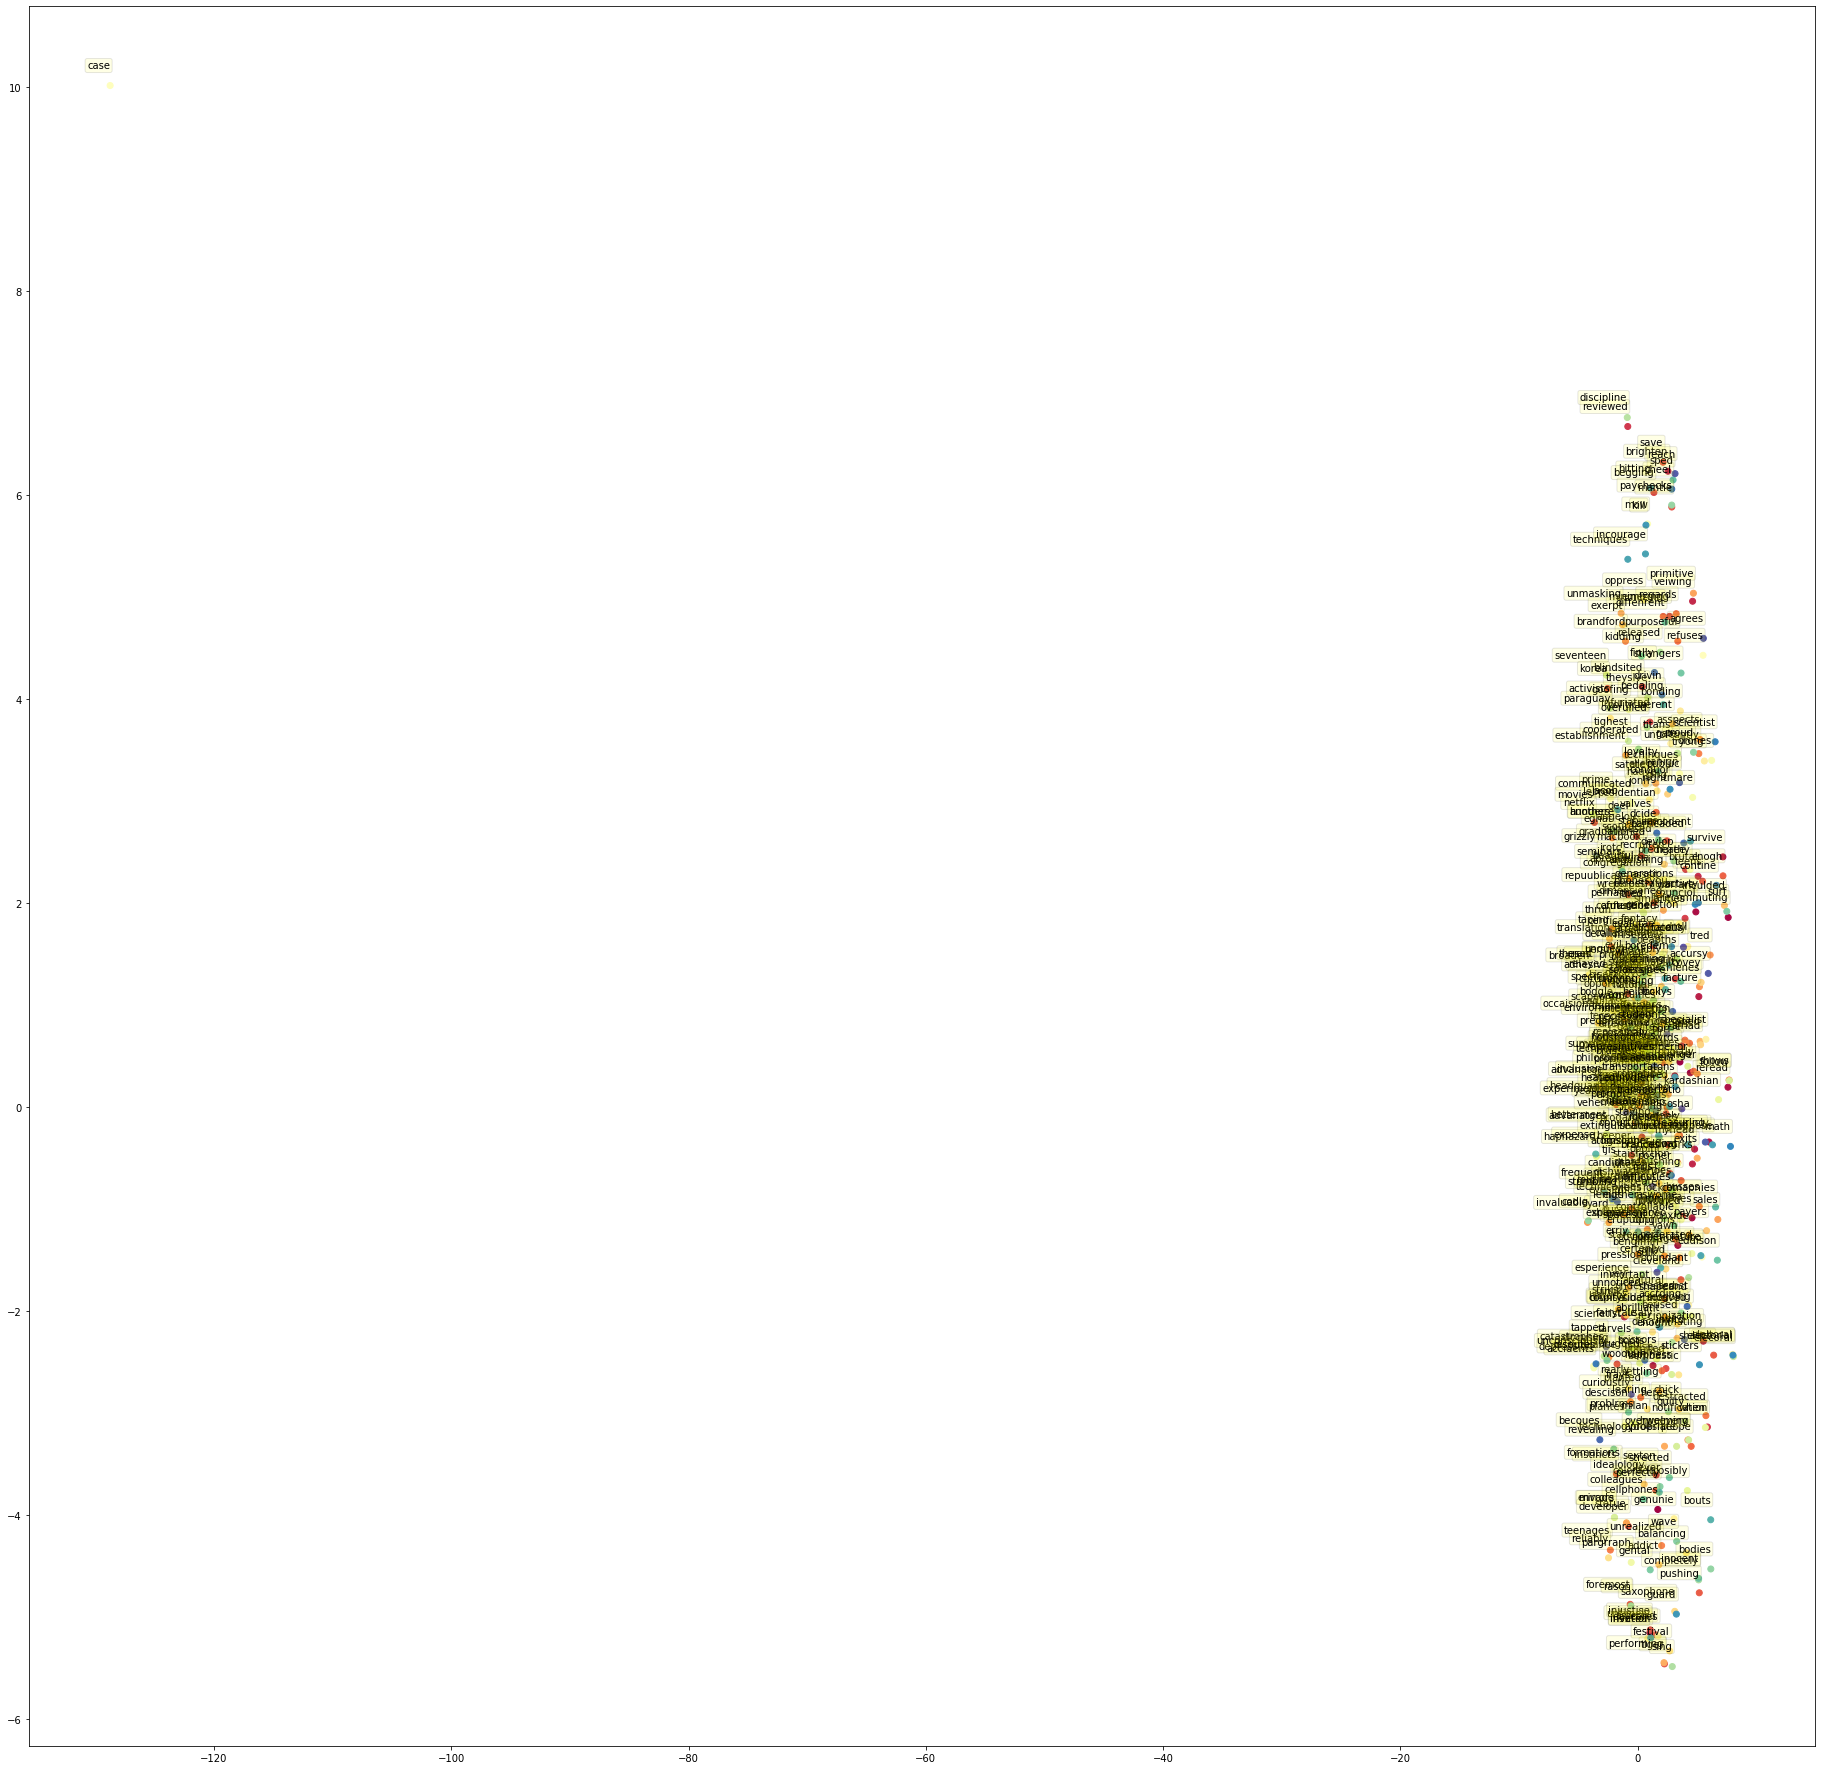

In [44]:
from sklearn.manifold import TSNE

n_samples = 500
# Sample random words from model dictionary
random_i = random.sample(range(vocab_size), n_samples)
random_w = [token2word(i) for i in random_i]

# Generate Word2Vec embeddings of each word
word_vecs = np.array([w2v_model[w] for w in random_w])

# Apply t-SNE to Word2Vec embeddings, reducing to 2 dims
tsne = TSNE()
tsne_e = tsne.fit_transform(word_vecs)

# Plot t-SNE result
plt.figure(figsize=(32, 32))
plt.scatter(tsne_e[:, 0], tsne_e[:, 1], marker='o', c=range(len(random_w)), cmap=plt.get_cmap('Spectral'))

for label, x, y, in zip(random_w, tsne_e[:, 0], tsne_e[:, 1]):
    plt.annotate(label,
                 xy=(x, y), xytext=(0, 15),
                 textcoords='offset points', ha='right', va='bottom',
                 bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.1))

## Basic ML Models

### 1. On simple averaging

In [45]:
## RF Model
rf_model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
rf_model.fit(x_train_text_embedding, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [47]:
rf_simple_pred = rf_model.predict(x_test_text_embedding)

In [61]:
accuracy_score(rf_simple_pred, y_test)

0.5776853776853776

In [62]:
rf_model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
rf_model.fit(x_train_text_tfidf_emb, y_train)
rf_simple_pred = rf_model.predict(x_test_text_tfidf_emb)
accuracy_score(rf_simple_pred, y_test)

0.5671517671517672

In [50]:
cm = confusion_matrix(rf_simple_pred, y_test)


In [55]:
cm_df = pd.DataFrame(cm, index = list(set(y_test)), columns = list(set(y_test)))

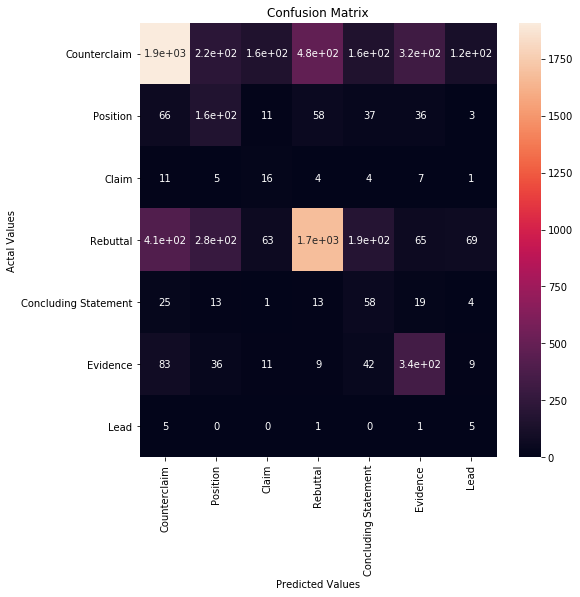

In [57]:
plt.figure(figsize=(8,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [63]:
## SVM CLassifier
svm_model = LinearSVC(C=1.0, dual= False, fit_intercept=True,
     intercept_scaling =0.1, max_iter=500,penalty = 'l2' , loss = 'squared_hinge', class_weight='balanced',
     multi_class='ovr', random_state=42, tol=1e-05, verbose=0)

svm_model.fit(x_train_text_embedding, y_train)
svm_pred = svm_model.predict(x_test_text_embedding)

In [64]:
accuracy_score(svm_pred, y_test)

0.4864864864864865

In [65]:
svm_model = LinearSVC(C=1.0, dual= False, fit_intercept=True,
     intercept_scaling =0.1, max_iter=500,penalty = 'l2' , loss = 'squared_hinge', class_weight='balanced',
     multi_class='ovr', random_state=42, tol=1e-05, verbose=0)

svm_model.fit(x_train_text_tfidf_emb, y_train)
svm_pred = svm_model.predict(x_test_text_tfidf_emb)

In [67]:
accuracy_score(svm_pred, y_test)

0.47914067914067915

### LSTM Model with training word embedding

In [124]:
len(x_train_text_embedding)

137078

In [125]:
y_label = pd.get_dummies(train['discourse_type'])
Y = y_label.values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (144293, 7)


In [126]:
label_names = y_label.columns
label_names

Index(['Claim', 'Concluding Statement', 'Counterclaim', 'Evidence', 'Lead',
       'Position', 'Rebuttal'],
      dtype='object')

In [127]:
lens_list = [len(i.split()) for i in train['discourse_text'] ]
max_length = max(lens_list)
max_ind =lens_list.index(max_length)
print('index of maximum lenght(longer sentence): ' ,max_ind )
print('maximum lenght is : ', max_length)

index of maximum lenght(longer sentence):  117554
maximum lenght is :  836


In [128]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = max_length
# This is fixed.
EMBEDDING_DIM = 300
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train['discourse_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 62068 unique tokens.


In [129]:
word_index

{'the': 1,
 'to': 2,
 'a': 3,
 'and': 4,
 'of': 5,
 'that': 6,
 'in': 7,
 'is': 8,
 'you': 9,
 'it': 10,
 'they': 11,
 'be': 12,
 'for': 13,
 'have': 14,
 'are': 15,
 'students': 16,
 'not': 17,
 'on': 18,
 'can': 19,
 'i': 20,
 'people': 21,
 'or': 22,
 'would': 23,
 'if': 24,
 'their': 25,
 'this': 26,
 'with': 27,
 'because': 28,
 'do': 29,
 'will': 30,
 'more': 31,
 'school': 32,
 'but': 33,
 'we': 34,
 'as': 35,
 'there': 36,
 'them': 37,
 'your': 38,
 'at': 39,
 'get': 40,
 'should': 41,
 'could': 42,
 'what': 43,
 'all': 44,
 'when': 45,
 'from': 46,
 'so': 47,
 'one': 48,
 'help': 49,
 'by': 50,
 'like': 51,
 'time': 52,
 'some': 53,
 'just': 54,
 'make': 55,
 'also': 56,
 'an': 57,
 'car': 58,
 'was': 59,
 'about': 60,
 'cars': 61,
 'many': 62,
 'think': 63,
 'student': 64,
 'other': 65,
 'who': 66,
 'has': 67,
 'how': 68,
 'up': 69,
 'work': 70,
 'electoral': 71,
 'out': 72,
 'even': 73,
 'good': 74,
 'college': 75,
 'our': 76,
 'better': 77,
 'know': 78,
 'want': 79,
 'way':

In [130]:
from keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(train['discourse_text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (144293, 836)


In [131]:
X

array([[  0,   0,   0, ...,  10, 103,  89],
       [  0,   0,   0, ...,   2,   3, 136],
       [  0,   0,   0, ...,  28,   5,  10],
       ...,
       [  0,   0,   0, ...,   5,  54,  48],
       [  0,   0,   0, ..., 291,  22, 590],
       [  0,   0,   0, ..., 148, 148, 148]], dtype=int32)

In [132]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(10, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 2
batch_size = 128

In [133]:
%%time
model.fit(X, Y,
          epochs=epochs,
          batch_size=batch_size,
          validation_split=0.1,
          callbacks=[ModelCheckpoint('best_model.h5', save_best_only = True)])


/Users/nehapawar/Desktop/neha/venv3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 129863 samples, validate on 14430 samples
Epoch 1/2
129863/129863 [==============================] - 910s 7ms/step - loss: 1.2329 - accuracy: 0.5897 - val_loss: 1.0199 - val_accuracy: 0.6785
Epoch 2/2
129863/129863 [==============================] - 957s 7ms/step - loss: 0.9646 - accuracy: 0.6789 - val_loss: 0.9436 - val_accuracy: 0.6878
CPU times: user 1h 29min 52s, sys: 1h 32min 51s, total: 3h 2min 44s
Wall time: 31min 7s


In [167]:
# import os
# test_names, test_texts = [], []
# for f in list(os.listdir('../../data/feedback-prize-2021/train')):
#     test_names.append(f.replace('.txt', ''))
#     test_texts.append(open('../../data/feedback-prize-2021/train/' + f, 'r').read())
    
    
# test_texts = pd.DataFrame({'id': test_names, 'text': test_texts})
# test_texts

In [177]:
TEST_PATH = "../../data/feedback-prize-2021/test"

def get_test_text(a_id):
    a_file = f"{TEST_PATH}/{a_id}.txt"
    with open(a_file, "r") as fp:
        txt = fp.read()
    return txt

def create_df_test():
    test_ids = [f[:-4] for f in os.listdir(TEST_PATH)] #Remove the last 4 characters ('.txt') in the filenames such as '0FB0700DAF44.txt'.
    test_data = []
    for test_id in test_ids:
        text = get_test_text(test_id)
        sentences = nltk.sent_tokenize(text)
        id_sentences = []
        idx = 0 
        for sentence in sentences:
            id_sentence = []
            words = sentence.split()
            # I created this heuristic for mapping words in sentences to "word indices"
            # This is not definitive and might have strong drawbacks and problems
            for w in words:
                id_sentence.append(idx)
                idx+=1
            id_sentences.append(id_sentence)
        test_data += list(zip([test_id] * len(sentences), sentences, id_sentences))
    df_test = pd.DataFrame(test_data, columns=['id', 'discourse_text', 'ids'])
    return df_test

In [178]:
# discourse_id = []
# discourse_text = []
# discourse_start =[] 
# discourse_end = []
# predictionstring = []
# for text in range(len(test_texts.text)):
#     doc = test_texts.text[text]
#     paras = re.split(r'[.]\n',doc)
#     start = 0
#     for para in paras:
#         positions = re.findall(r'\w+[.]', para)
#         if len(positions) <=2 :
#             txts = re.split(r'[.]\s',para)
#             for i in txts:
#                 discourse_text.append(i)
#                 length = len(i.split())
#                 end = start + length
#                 l = list(range(start+1,end+1 ))
#                 l = [str(j) for j in l]
#                 l = ' '.join(l)
#                 predictionstring.append(l)
#                 discourse_start.append(start+1)
#                 discourse_end.append(end)
#                 discourse_id.append(test_texts.id[text])
#                 start += length

#         else: 
#             if len(positions)%2 == 0:
#                 split_pos = int(len(positions)/2)
#                 split_word = positions[split_pos]
#             else :
#                 split_pos = int((len(positions)+1)/2)
#                 split_word = positions[split_pos]

#             words = para.split(' ')
#             position = words.index(split_word)
#             part1 = words[:position]
#             part2 = words[position:]
#             part1 = ' '.join(part1)
#             part2 = ' '.join(part2)
#             parts = [part1 ,part2]
#             for i in parts:
#                 discourse_text.append(i)
#                 length = len(i.split())
#                 end = start + length
#                 l = list(range(start+1,end+1 ))
#                 l = [str(k) for k in l]
#                 l = ' '.join(l)
#                 predictionstring.append(l)
#                 discourse_start.append(start+1)
#                 discourse_end.append(end)
#                 discourse_id.append(test_texts.id[text])
#                 start += length

# testing_data =pd.DataFrame() 
# testing_data['discourse_id'] =discourse_id
# testing_data['discourse_text'] = discourse_text
# testing_data['discourse_start'] = discourse_start
# testing_data['discourse_end'] = discourse_end
# testing_data['predictionstring'] = predictionstring
# testing_data.head()

In [179]:
testing_data = create_df_test()
testing_data.head()

,id,discourse_text,ids
0,DF920E0A7337,Have you ever asked more than one person for h...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,DF920E0A7337,Interviews are a perfect example of seeking mo...,"[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]"
2,DF920E0A7337,"Interviews are seen on the news, in profession...","[29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4..."
3,DF920E0A7337,There are a lot of people that can help you bu...,"[43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 5..."
4,DF920E0A7337,They can all open you up to new ideas.,"[59, 60, 61, 62, 63, 64, 65, 66, 67]"


In [180]:
testing_data['predictionstring'] = testing_data['ids'].apply(lambda x: ' '.join([str(i) for i in x]))
testing_data.head()

,id,discourse_text,ids,predictionstring
0,DF920E0A7337,Have you ever asked more than one person for h...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17
1,DF920E0A7337,Interviews are a perfect example of seeking mo...,"[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]",18 19 20 21 22 23 24 25 26 27 28
2,DF920E0A7337,"Interviews are seen on the news, in profession...","[29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4...",29 30 31 32 33 34 35 36 37 38 39 40 41 42
3,DF920E0A7337,There are a lot of people that can help you bu...,"[43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 5...",43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
4,DF920E0A7337,They can all open you up to new ideas.,"[59, 60, 61, 62, 63, 64, 65, 66, 67]",59 60 61 62 63 64 65 66 67


In [181]:
testing_data = testing_data.drop('ids', axis=1)


In [182]:
testing_data['cleaned_text'] = testing_data.discourse_text.apply(clean_text)


In [183]:
X_test = tokenizer.texts_to_sequences(testing_data['cleaned_text'].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_test.shape)

Shape of data tensor: (187, 836)


In [184]:
y_pred = model.predict(X_test)

In [186]:
y_pred[:10]

array([[0.46672836, 0.02543342, 0.21261284, 0.07329556, 0.09879909,
        0.06649874, 0.05663198],
       [0.4788117 , 0.02484627, 0.04123255, 0.2590218 , 0.03199809,
        0.05902621, 0.10506336],
       [0.863521  , 0.00200665, 0.03778341, 0.04613342, 0.00471729,
        0.00826378, 0.03757444],
       [0.77319086, 0.01116504, 0.05390802, 0.04507124, 0.01870908,
        0.05123031, 0.04672553],
       [0.81367904, 0.00373657, 0.08045027, 0.03089632, 0.01377811,
        0.02244443, 0.03501533],
       [0.356769  , 0.15620373, 0.0107301 , 0.0573498 , 0.04307808,
        0.3514137 , 0.02445551],
       [0.8473938 , 0.0040844 , 0.02865901, 0.05894354, 0.0069909 ,
        0.01929762, 0.03463075],
       [0.54772276, 0.04913479, 0.02705093, 0.05064316, 0.03062173,
        0.257109  , 0.03771765],
       [0.63466364, 0.04540987, 0.02214305, 0.07539252, 0.02767819,
        0.1567005 , 0.03801208],
       [0.7326386 , 0.01169398, 0.04696111, 0.12131483, 0.01723553,
        0.01997655, 0.0

In [187]:
output = pd.DataFrame(y_pred ,columns= label_names)
output = list(output.idxmax(axis = 1))
submission_df = pd.DataFrame()
submission_df['id'] = testing_data['id']
submission_df['class'] = output# label of y_predict
submission_df['predictionstring'] = testing_data['predictionstring']
mapping = { 1:'Claim' , 2:'Evidence' ,  3:'Position' , 4:'Concluding Statement' , 5:'Lead', 6:'Counterclaim', 7:'Rebuttal' }
submission_df['class']= submission_df['class'].replace(mapping)
submission_df.head()

,id,class,predictionstring
0,DF920E0A7337,Claim,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17
1,DF920E0A7337,Claim,18 19 20 21 22 23 24 25 26 27 28
2,DF920E0A7337,Claim,29 30 31 32 33 34 35 36 37 38 39 40 41 42
3,DF920E0A7337,Claim,43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
4,DF920E0A7337,Claim,59 60 61 62 63 64 65 66 67


In [196]:
submission_df['class'].value_counts()

Claim                   165
Position                  8
Concluding Statement      5
Counterclaim              4
Evidence                  3
Lead                      2
Name: class, dtype: int64

In [191]:
train['discourse_type'].value_counts()

Claim                   50208
Evidence                45702
Position                15419
Concluding Statement    13505
Lead                     9305
Counterclaim             5817
Rebuttal                 4337
Name: discourse_type, dtype: int64

In [189]:
submission_df.shape

(187, 3)

In [195]:
submission_df.head(20)

,id,class,predictionstring
0,DF920E0A7337,Claim,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17
1,DF920E0A7337,Claim,18 19 20 21 22 23 24 25 26 27 28
2,DF920E0A7337,Claim,29 30 31 32 33 34 35 36 37 38 39 40 41 42
3,DF920E0A7337,Claim,43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
4,DF920E0A7337,Claim,59 60 61 62 63 64 65 66 67
5,DF920E0A7337,Claim,68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 8...
6,DF920E0A7337,Claim,108 109 110 111 112 113 114 115 116 117
7,DF920E0A7337,Claim,118 119 120 121 122 123 124 125 126 127 128 12...
8,DF920E0A7337,Claim,135 136 137 138 139 140 141 142 143 144 145 14...
9,DF920E0A7337,Claim,152 153 154 155 156 157 158 159 160 161 162 16...


In [ ]:
submission_df.to_csv("submission.csv", index=False)

## LSTM with word2vec embedding

In [92]:
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))


Vocabulary Size: 49636 - Embedding Dim: 100


In [94]:
MAX_SEQUENCE_LENGTH

836

In [91]:
w2v_model.wv.most_similar('like')


[('love', 0.5449956059455872),
 ('weird', 0.5133236646652222),
 ('hate', 0.4992471933364868),
 ('cool', 0.49104708433151245),
 ('bombastic', 0.4842549264431),
 ('crazy', 0.46580958366394043),
 ('quilty', 0.46006035804748535),
 ('fuler', 0.45846402645111084),
 ('stupid', 0.4528875946998596),
 ('blairing', 0.45263880491256714)]

In [93]:
word_vec_dict={}
for word in vocab:
    word_vec_dict[word]=w2v_model.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict)) # should come equal to vocab size
  

The no of key-value pairs :  49636


In [96]:
embed_matrix=np.zeros(shape=(vocab_size,embedding_size))

In [97]:
embed_matrix.shape

(49636, 100)

In [95]:
embed_matrix=np.zeros(shape=(vocab_size,embedding_size))
for word,i in tokenizer.word_index.items():
    embed_vector=word_vec_dict.get(word)
    if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
        embed_matrix[i]=embed_vector

IndexError: index 49636 is out of bounds for axis 0 with size 49636

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(10, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [99]:
model = Sequential()

# Keras Embedding layer with Word2Vec weights initialization
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(10, dropout=0.4))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X, Y,
          epochs=epochs,
          batch_size=batch_size,
          validation_split=0.1,
          callbacks=[ModelCheckpoint('best_model.h5', save_best_only = True)])


Train on 129863 samples, validate on 14430 samples
Epoch 1/2
129863/129863 [==============================] - 721s 6ms/step - loss: 1.6690 - accuracy: 0.3322 - val_loss: 1.4643 - val_accuracy: 0.4075
Epoch 2/2
129863/129863 [==============================] - 592s 5ms/step - loss: 1.5990 - accuracy: 0.3642 - val_loss: 1.4503 - val_accuracy: 0.4227
